In [3]:
from IPython.core.display import Image
from imdbpie import Imdb
import pandas as pd
import plotly as pt
from matplotlib import pyplot as plt
import numpy as np
from sklearn import cross_validation, preprocessing
import time
import requests
import bs4
from bs4 import BeautifulSoup
import cPickle
import seaborn as sns
import re
from matplotlib import cm
from matplotlib.colors import ColorConverter

% matplotlib inline

In [4]:



# import statsmodels.api as st
# import sklearn
# from sklearn import linear_model as lm
# from sklearn import cross_validation, preprocessing
# import matplotlib.cm as cm
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import roc_curve
# from sklearn.metrics import roc_auc_score
# from sklearn.cross_validation import train_test_split
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import precision_score
# from sklearn.metrics import recall_score
# from sklearn.cross_validation import train_test_split
# from sklearn.cross_validation import cross_val_predict
# from sklearn.cross_validation import cross_val_score
# import matplotlib.patheffects as path_effects
# from sklearn.metrics import mean_squared_error

In [5]:
imdb = Imdb()
imdb = Imdb(anonymize=True)
imdb = Imdb(cache=True)

In [6]:
top = imdb.top_250()

In [7]:
top = pd.DataFrame(top)

In [8]:
len(top)

250

In [9]:
top.head()

,can_rate,image,num_votes,rating,tconst,title,type,year
0,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1679913,9.3,tt0111161,The Shawshank Redemption,feature,1994
1,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1149354,9.2,tt0068646,The Godfather,feature,1972
2,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,786040,9.0,tt0071562,The Godfather: Part II,feature,1974
3,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,1664956,9.0,tt0468569,The Dark Knight,feature,2008
4,True,{u'url': u'http://ia.media-imdb.com/images/M/M...,859779,8.9,tt0108052,Schindler's List,feature,1993


In [10]:
top['image'][0]

{u'height': 1388,
 u'url': u'http://ia.media-imdb.com/images/M/MV5BODU4MjU4NjIwNl5BMl5BanBnXkFtZTgwMDU2MjEyMDE@._V1_.jpg',
 u'width': 933}

In [11]:
del top['image']

In [12]:
top.dtypes

can_rate        bool
num_votes      int64
rating       float64
tconst        object
title         object
type          object
year          object
dtype: object

In [13]:
top['can_rate'].value_counts()

True    250
Name: can_rate, dtype: int64

In [14]:
del top['can_rate']

In [15]:
top['type'].value_counts()

feature    250
Name: type, dtype: int64

In [16]:
del top['type']

In [17]:
top['year'] = top['year'].apply(lambda x: int(x))

In [18]:
top['num_votes'].describe()

count    2.500000e+02
mean     4.033579e+05
std      3.310560e+05
min      2.508900e+04
25%      1.229030e+05
50%      3.235895e+05
75%      5.947830e+05
max      1.679913e+06
Name: num_votes, dtype: float64

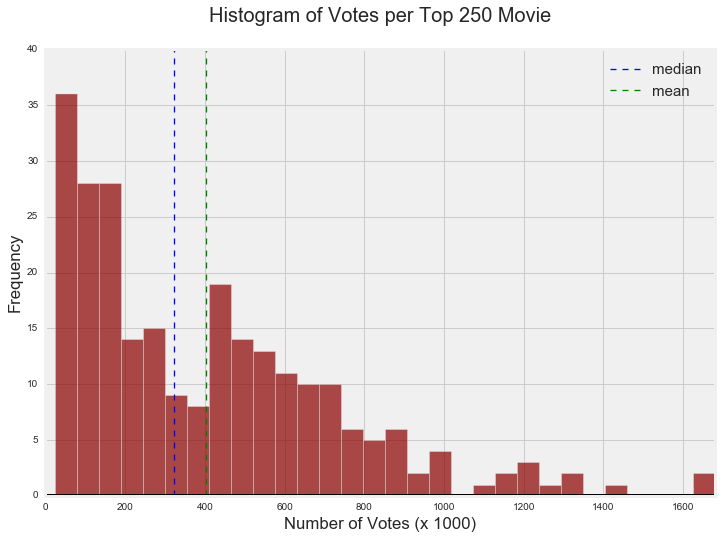

In [19]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['num_votes']/1000, color = 'darkred', bins = 30, alpha = 0.7)
plt.axvline(top['num_votes'].median()/1000, color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['num_votes'].mean()/1000, color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Votes per Top 250 Movie', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Number of Votes (x 1000)')

plt.xlim([0, max(top['num_votes']/1000)])
plt.ylim([0, 40])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

Which movies have more than a million votes?

In [20]:
top[top['num_votes'] > 1000000][['title', 'year']].sort('year')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
1,The Godfather,1972
0,The Shawshank Redemption,1994
6,Pulp Fiction,1994
12,Forrest Gump,1994
21,Se7en,1995
9,Fight Club,1999
17,The Matrix,1999
10,The Lord of the Rings: The Fellowship of the Ring,2001
14,The Lord of the Rings: The Two Towers,2002
7,The Lord of the Rings: The Return of the King,2003


In [21]:
top['rating'].describe()

count    250.000000
mean       8.315200
std        0.231133
min        8.000000
25%        8.100000
50%        8.300000
75%        8.400000
max        9.300000
Name: rating, dtype: float64

Remember: minimum rating is so high because we're only looking at top 250 movies!

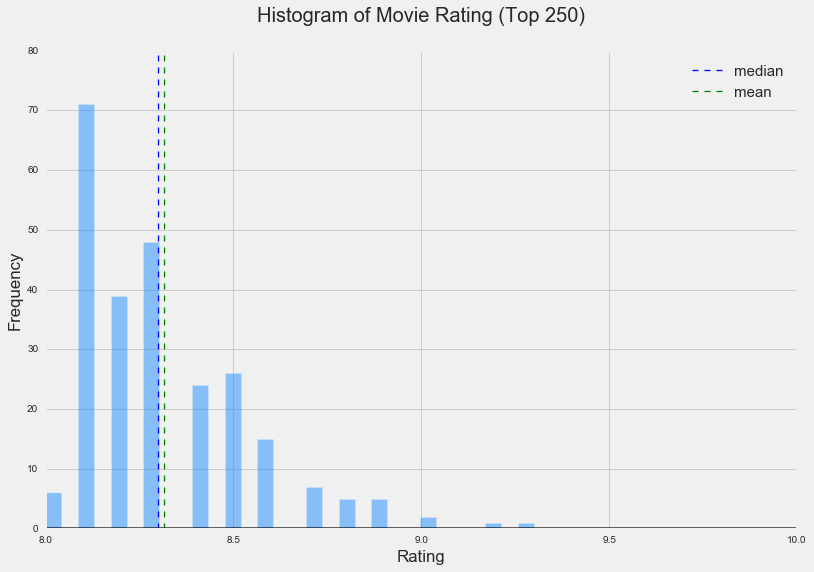

In [22]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['rating'], color = 'dodgerblue', alpha = 0.5, bins = 30)
plt.axvline(top['rating'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['rating'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('Histogram of Movie Rating (Top 250)', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Rating')

plt.xlim([min(top['rating']), 10])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

In [23]:
top['year'].describe()

count     250.000000
mean     1984.028000
std        24.152361
min      1921.000000
25%      1964.000000
50%      1991.000000
75%      2003.750000
max      2016.000000
Name: year, dtype: float64

In the histogram below, each bar slot represents one year:

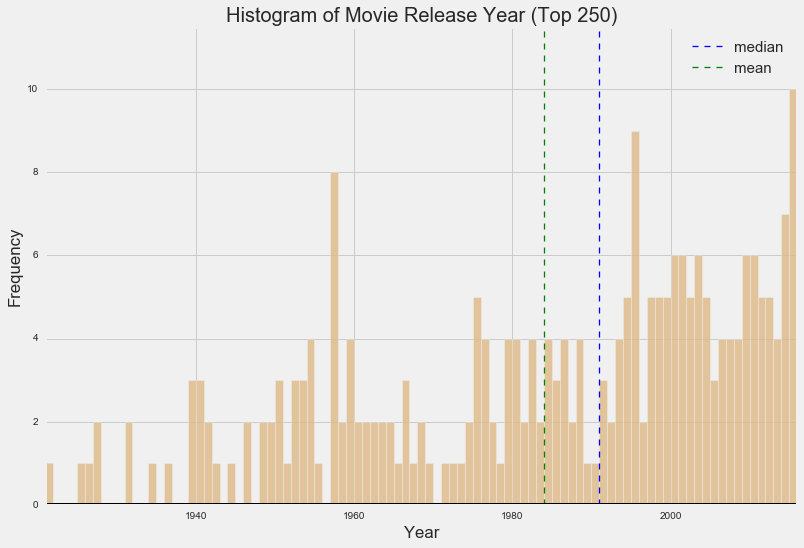

In [24]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top['year'], color = 'burlywood', alpha = 0.8, bins = 95)
plt.axvline(top['year'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top['year'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Movie Release Year (Top 250)', fontsize = 20)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Year')

plt.xlim([min(top['year']), max(top['year'])])
plt.ylim([0, 11.5])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

1957 was a good year:

In [25]:
top[top['year'] == 1957][['title', 'year']]

,title,year
5,12 Angry Men,1957
56,Paths of Glory,1957
71,Witness for the Prosecution,1957
131,The Bridge on the River Kwai,1957
134,The Seventh Seal,1957
140,Wild Strawberries,1957
174,Nights of Cabiria,1957
245,Throne of Blood,1957


As was 1995:

In [26]:
top[top['year'] == 1995][['title', 'year']]

,title,year
21,Se7en,1995
24,The Usual Suspects,1995
75,Braveheart,1995
91,Toy Story,1995
122,Heat,1995
138,Casino,1995
205,Before Sunrise,1995
219,Twelve Monkeys,1995
227,La Haine,1995


The spike farthest to the right on the histogram is combined 2015 and 2016-to-date:

In [27]:
top[(top['year'] == 2015) | (top['year'] == 2016)][['title', 'year']].sort('year')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year
118,Inside Out,2015
123,Room,2015
141,Star Wars: The Force Awakens,2015
180,Spotlight,2015
183,Mad Max: Fury Road,2015
213,The Revenant,2015
232,The Martian,2015
159,Captain America: Civil War,2016
178,Zootopia,2016
203,Deadpool,2016


In [28]:
top_scaled = preprocessing.scale(top[['num_votes', 'rating', 'year']])
top_scaled = pd.DataFrame(top_scaled, columns = ['num_votes', 'rating', 'year'])

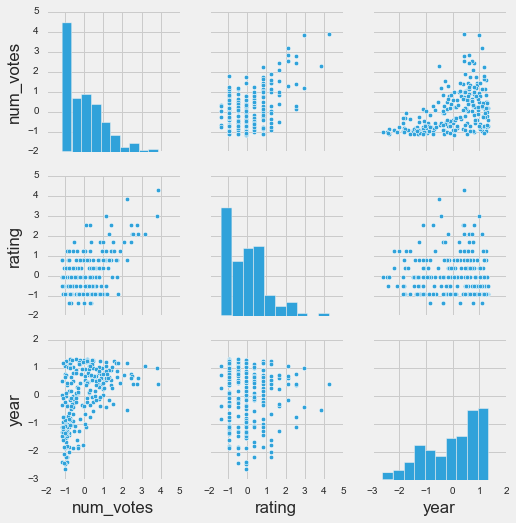

In [29]:
sns.pairplot(top_scaled)

Let's dig a little deeper into these plots...  

We'll use 'rating' to assign the area of points on a scatterplot of number of votes vs. year of movie release.  If we just try dividing by a constant, the difference in size is not readily apparent, so let's try normalizing!

In [30]:
top_scaled['rating'].describe()

count    2.500000e+02
mean     3.674838e-15
std      1.002006e+00
min     -1.366450e+00
25%     -9.329318e-01
50%     -6.589481e-02
75%      3.676237e-01
max      4.269290e+00
Name: rating, dtype: float64

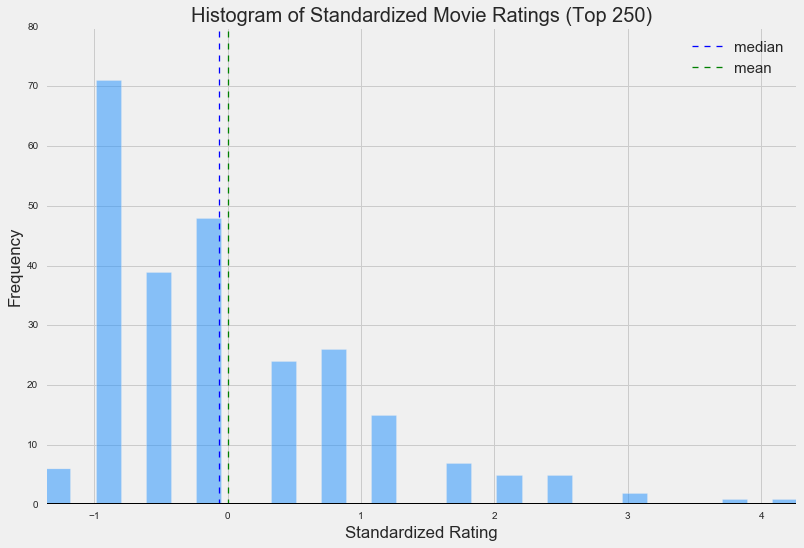

In [31]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

df_hist = plt.hist(top_scaled['rating'], color = 'dodgerblue', alpha = 0.5, bins = 30)
plt.axvline(top_scaled['rating'].median(), color='b', linestyle='dashed', linewidth=1.3, label = 'median')
plt.axvline(top_scaled['rating'].mean(), color='g', linestyle='dashed', linewidth=1.3, label = 'mean')
plt.axhline(0, color='black')
plt.title('Histogram of Standardized Movie Ratings (Top 250)', fontsize = 20)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Standardized Rating')

plt.xlim([min(top_scaled['rating']), max(top_scaled['rating'])])
#plt.ylim([-10, 85])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

If we use the standardized ratings multiplied by a constant, though, we'll have a negative area assigned to everything under the mean!  Can't have that.  Let's add a little more than the minimum value to every standardized rating and then multiply by a constant:

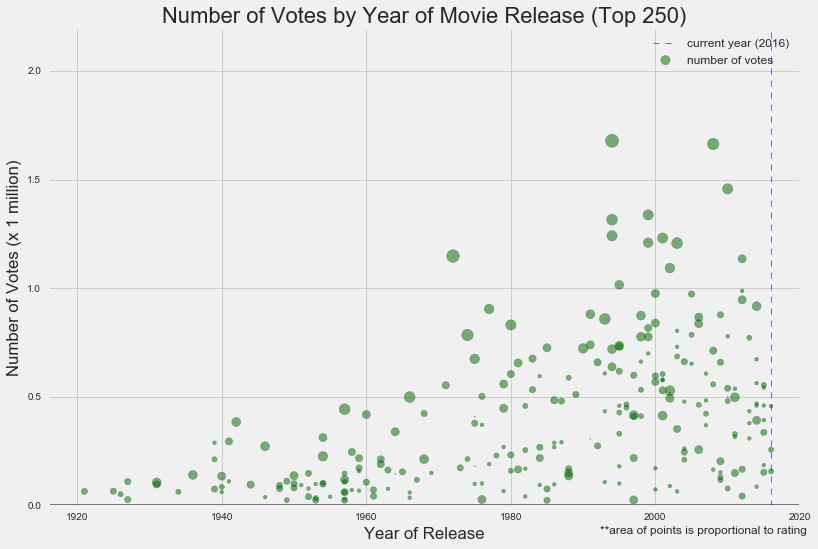

In [32]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

area = (top_scaled['rating'] + 1.4)*30

plt.scatter(top['year'], top['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'number of votes')

plt.title('Number of Votes by Year of Movie Release (Top 250)', fontsize = 22)
plt.axhline(0, color='black', alpha = 0.5)
plt.axvline(2016, color='b', linestyle='dashed', alpha = 0.7, linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 2.2])
plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('**area of points is proportional to rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

In [33]:
top_scaled['year'].describe()

count    2.500000e+02
mean    -8.291146e-16
std      1.002006e+00
min     -2.614835e+00
25%     -8.308991e-01
50%      2.892465e-01
75%      8.182042e-01
max      1.326418e+00
Name: year, dtype: float64

The plot below is not as 'nice-looking' as the previous one; let's scrape imdb.com to find some more variables!

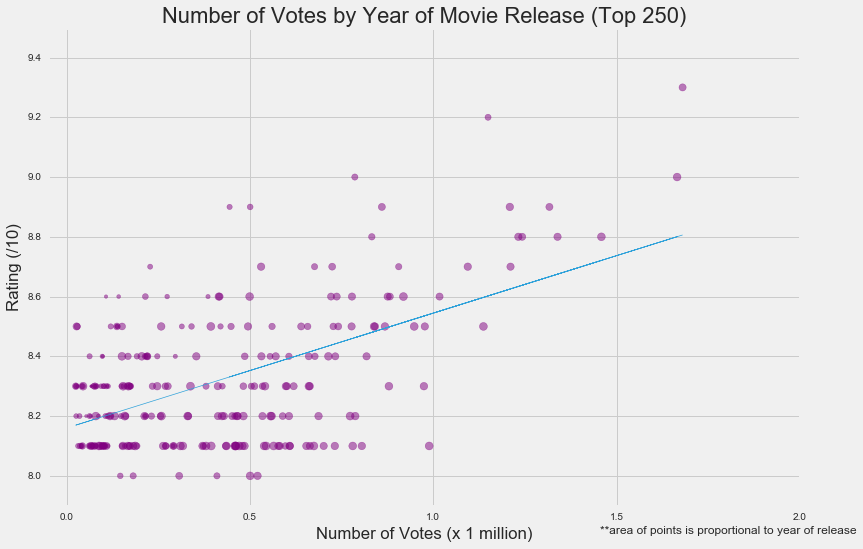

In [37]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# def rand_jitter(arr):
#     stdev = .005*(max(arr)-min(arr))
#     return arr + np.random.randn(len(arr)) * stdev

# def jitter(x, y, s=10, marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, \
#            verts=None, hold=None, **kwargs):
#     return plt.scatter(rand_jitter(x), rand_jitter(y), s=s, marker=marker, cmap=cmap, norm=norm, vmin=vmin, \
#                        vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts, hold=hold, **kwargs)
#jitter(top['num_votes']/1000000, top['rating'], color = 'purple', alpha = 0.5, s = area)

area = (top_scaled['year'] + 3)*15

plt.scatter(top['num_votes']/1000000, top['rating'], color = 'purple', alpha = 0.5, s = area)

plt.title('Number of Votes by Year of Movie Release (Top 250)', fontsize = 22)
plt.axhline(0, color='darkblue', alpha = 0.5)
# y label
plt.ylabel('Rating (/10)')

# x label
plt.xlabel('Number of Votes (x 1 million)')

# set the figure boundaries
plt.xlim([-0.05, 2])
plt.ylim([7.9, 9.5])
plt.grid(True)

m, b = np.polyfit(top['num_votes']/1000000, top['rating'], 1)

plt.plot(top['num_votes']/1000000, m*top['num_votes']/1000000 + b, '-', linewidth = 0.7)

plt.annotate('**area of points is proportional to year of release', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

## jitter assistance from:
## http://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot

Let's use an API to get what we can:

In [38]:
# certification = []
# for movie in top['tconst']:
#     time.sleep(1)
#     title = imdb.get_title_by_id(movie)
#     cert = title.certification
#     certification.append(cert)
    
# if len(certification) == 250:
#     certification = pd.DataFrame(certification, columns = ['cert'])
#     certification.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv', index = False)
#     top['cert'] = certification
# else:
#     print 'Uh oh!  We didn\'t get 250 observations!  There are %s instead :(' %len(certification)

In [39]:
certification = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/certification.csv')
certification.columns = ['cert']
top['cert'] = certification

In [40]:
top['cert'].value_counts()

R            92
Not Rated    33
PG           32
PG-13        30
Approved     14
Unrated      12
G            10
TV-PG         9
TV-14         6
TV-MA         4
Passed        3
M             2
X             1
TV-G          1
E             1
Name: cert, dtype: int64

Let's consolidate these as much as possible.  Examine (imdb.com, wikipedia) each certification except 'R', 'PG', 'PG-13', 'G'.  We'll assume those have been categorized properly.  Update if necessary. 

In [41]:
top['cert'][101] = 'PG-13' # Indiana Jones and the Last Crusade
top['cert'][91] = 'G' # Toy Story
top['cert'][78] = 'R' # A Clockwork Orange
top['cert'][34] = 'G' # City Lights
top['cert'][80] = 'Not Rated' # Double Indemnity
top['cert'][215] = 'G' # Wizard of Oz 
top['cert'][27] = 'PG-13' # Once Upon a Time in the West
top['cert'][241] = 'R' # A Fistful of Dollars
top['cert'][9] = 'R' # Fight Club
top['cert'][29] = 'R' # Saving Private Ryan
top['cert'][74] = 'R' # Reservoir Dogs
top['cert'][96] = 'R' # L.A. Confidential
top['cert'][30] = 'R' # American History X
top['cert'][40] = 'R' # Terminator 2: Judgment Day
top['cert'][52] = 'R' # Alien
top['cert'][64] = 'PG-13' # Princess Mononoke
top['cert'][100] = 'R' # Scarface
top['cert'][145] = 'Not Rated' # Judgment at Nuremberg
top['cert'][18] = 'Not Rated' # Seven Samurai
top['cert'][26] = 'R' # Léon: The Professional
top['cert'][59] = 'Not Rated' # Grave of the Fireflies
top['cert'][77] = 'R' # Requiem for a Dream
top['cert'][99] = 'Not Rated' # Rashomon
top['cert'][106] = 'Not Rated' # Yojimbo
top['cert'][139] = 'Not Rated' # The General
top['cert'][140] = 'Not Rated' # Wild Strawberries
top['cert'][171] = 'Not Rated' # It Happened One Night
top['cert'][209] = 'Not Rated' # Diabolique
top['cert'][210] = 'Not Rated' # Memories of Murder
top['cert'][245] = 'Not Rated' # Throne of Blood
top['cert'][32] = 'PG' # Casablanca
top['cert'][104] = 'Approved' # All About Eve
top['cert'][109] = 'Not Rated' # The Treasure of the Sierra Madre
top['cert'][137] = 'PG' # Howl's Moving Castle
top['cert'][158] = 'G' # Gone With the Wind
top['cert'][196] = 'G' # Ben-Hur
top['cert'][216] = 'G' # Monsters, Inc.
top['cert'][223] = 'PG' # Strangers on a Train
top['cert'][242] = 'PG' # Castle in the Sky
top['cert'][23] = 'PG' # It's a Wonderful Life
top['cert'][33] = 'R' # Psycho
top['cert'][39] = 'PG' # Rear Window
top['cert'][50] = 'PG' # Dr. Strangelove
top['cert'][70] = 'PG' # Vertigo
top['cert'][131] = 'PG' # Bridge on the River Kwai

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning:


A value is trying 

Muuuuuch nicer:

In [42]:
top['cert'].value_counts()

R            105
Not Rated     46
PG            41
PG-13         33
G             16
Approved       9
Name: cert, dtype: int64

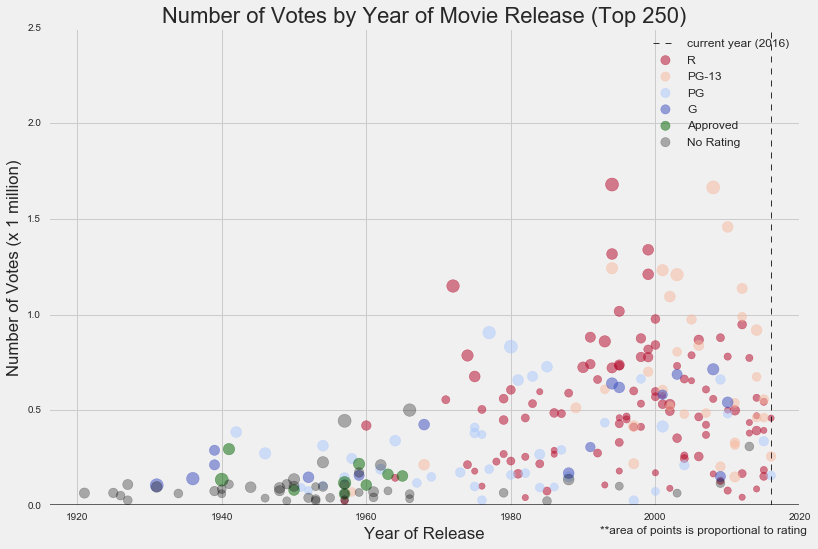

In [43]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# subset dataframe by certification
top_R = top[top['cert'] == 'R']
top_NR = top[top['cert'] == 'Not Rated']
top_PG = top[top['cert'] == 'PG']
top_PG13 = top[top['cert'] == 'PG-13']
top_G = top[top['cert'] == 'G']
top_Approved = top[top['cert'] == 'Approved']

# assign colors to ranked certifications
cert = ['G', 'PG', 'PG-13', 'R']
cert_colors = []
for i in range(0, 256, 256/3):
    cert_colors.append(cm.coolwarm(i))
cert_dict = dict(zip(cert, cert_colors))

# set area of dot proportional-ish to rating
area = (top_scaled['rating'] + 1.4)*30

# plot number of votes by year of release
plt.scatter(top_R['year'], top_R['num_votes']/1000000, color = cert_dict['R'], alpha = 0.5, s = area, label = 'R')
plt.scatter(top_PG13['year'], top_PG13['num_votes']/1000000, color = cert_dict['PG-13'], alpha = 0.5, s = area, \
            label = 'PG-13')
plt.scatter(top_PG['year'], top_PG['num_votes']/1000000, color = cert_dict['PG'], alpha = 0.5, s = area, label = 'PG')
plt.scatter(top_G['year'], top_G['num_votes']/1000000, color = cert_dict['G'], alpha = 0.5, s = area, label = 'G')
plt.scatter(top_Approved['year'], top_Approved['num_votes']/1000000, color = 'darkgreen', alpha = 0.5, s = area, \
            label = 'Approved')
plt.scatter(top_NR['year'], top_NR['num_votes']/1000000, color = 'black', alpha = 0.3, s = area, label = 'No Rating')

plt.title('Number of Votes by Year of Movie Release (Top 250)', fontsize = 22)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 2.5])

plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('**area of points is proportional to rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

In [44]:
top.head(1)

,num_votes,rating,tconst,title,year,cert
0,1679913,9.3,tt0111161,The Shawshank Redemption,1994,R


In [45]:
top = top[['tconst', 'title', 'year', 'cert', 'rating', 'num_votes']]

Do we want to consider actors?  Not for now.  Do not run the following two cells.

In [48]:
# cast = []
# for movie in top['tconst']:
#     lil_cast = []
#     time.sleep(2)
#     title = imdb.get_title_by_id(movie)
#     creds = title.credits
#     for i in [0, 1, 2]:
#         lil_cast.append(creds[i])
#     cast.append(lil_cast)

# len(cast)

In [49]:
# cast = pd.DataFrame(cast)
# cast.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/cast.csv', index = False)
# top['cast'] = cast

OK!  Enough of that... now let's use scraped data.  To perform the scrape, uncomment and run cell below; otherwise, load from file in the following cell:

In [50]:
# URL = 'http://www.imdb.com/title/'
# paths = top['tconst']
# soup = []
# for i in paths:
#     time.sleep(1)
#     request = requests.get(URL + i + '/')
#     if str(request) != '<Response [200]>':
#         print URL + i + '/'
#     tiny_soup = BeautifulSoup(request.content, "lxml")
#     soup.append(tiny_soup)

# cPickle.dump(soup, open('movie_soup.p', 'wb')) 

HERE IS THE SOUP:

In [51]:
# soup = cPickle.load(open('/Users/Rebecca/DSI-projects/projects/project-06/assets/movie_soup.p', 'rb'))

In [52]:
# running_time = []
# for i in range(len(soup)):
#     times = []
#     for j in soup[i].find_all('time', itemprop = 'duration'):
#         times.append(j.text.encode('utf8'))
#     running_time.append(times[0])
#
# for i in range(len(running_time)):
#     split_time = []
#     clean_time = running_time[i].replace('\n                        ', '')
#     clean_time = clean_time.replace('min\n                    ', '')
#     split_time = clean_time.split('h ')
#     split_time[0] = split_time[0].replace('h\n                    ', '')
#     if len(split_time) == 1:
#         minutes = float(split_time[0]) * 60
#         running_time[i] = int(minutes) 
#     else:
#         minutes = float(split_time[0]) * 60 + float(split_time[1])
#         running_time[i] = int(minutes)
        
# run_time = pd.DataFrame(running_time, columns = ['run_time'])
# run_time.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv', index = False)

In [53]:
run_time = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/run_time.csv')
top['run_time'] = run_time

In [117]:
# genre = []
# for i in range(len(soup)):
#     genres = []
#     for j in soup[i].find_all('span', itemprop = 'genre'):
#         genres.append(j.text.encode('utf8'))
#     genre.append(genres)

# for i in range(len(genre)):
#     genre[i] = str(genre[i])
    
# genre = pd.DataFrame(genre, columns = ['genre])
# genre.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv', index = False)

In [55]:
genre = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/genre.csv')
genre.columns = ['genre']
top['genre'] = genre

In [69]:
# release_info = []
# for i in range(len(soup)):
#     info = []
#     for j in soup[i].find_all('a', title = 'See more release dates'):
#         info.append(j.text.encode('utf8'))
#     release_info.append(info)

# month = []
# country = []
# for i in range(len(release_info)):
#     month_country = []
#     release_info[i] = str(release_info[i])
#     clean = release_info[i].replace(')\\n\\n\']', '')
#     split = clean.split(' ')
#     if len(split) == 4:
#         month.append(split[1])
#         split[3] = split[3].replace('(', '')
#         country.append(split[3])
#     else:
#         month.append(split)
#         country.append(split)

# all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
#              'November', 'December']

# for i in range(len(top)):
#     if top['month'][i] in all_months:
#         continue
#     else:
#         print top.loc[i]
#         print '\n'

Correct the ones that came through in different format and look up month for 'The Gold Rush' (thanks, Wikipedia!):

In [70]:
# top['month'][5] = 'April'
# top['country'][5] = 'USA'
# top['month'][56] = 'October'
# top['country'][56] = 'West Germany'
# top['month'][65] = 'November'
# top['country'][65] = 'South Korea'
# top['month'][129] = 'June'
# top['country'][129] = 'Germany'
# top['month'][210] = 'May'
# top['country'][210] = 'South Korea'
# top['month'][224] = 'December'
# top['country'][224] = 'Hong Kong'

In [68]:
# top['country'].value_counts()

USA             203
UK               10
Japan             8
France            6
Sweden            4
Australia         2
Argentina         2
South Korea       2
Hong Kong         1
Singapore         1
China             1
Iran              1
Netherlands       1
India             1
West Germany      1
Philippines       1
Denmark           1
Hungary           1
Germany           1
Italy             1
Brazil            1
Name: country, dtype: int64

In [73]:
# month = pd.DataFrame(top['month'], columns = ['month'])
# country = pd.DataFrame(top['country'], columns = ['country'])
# month.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv', index = False)
# country.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv', index = False)

In [56]:
month = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/month.csv')
country = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/country.csv')
top['month'] = month
top['country'] = country

Hey, I know!  Let's practice using dictionaries.  We'll make a bar plot of movie counts by month and put the bars in order of month (not in order of count):

In [57]:
y = pd.DataFrame(top['month'].value_counts())
y.columns = ['count']
y['month'] = y.index
y = y.reset_index(drop = True)
order = range(12)
all_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', \
              'November', 'December']
month_dict = dict(zip(all_months, order))
y['order'] = y['month'].apply(lambda x: month_dict[x])
y = y.sort('order')
del y['order']
y = y.set_index(y['month'], drop = False)
del y['month']

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



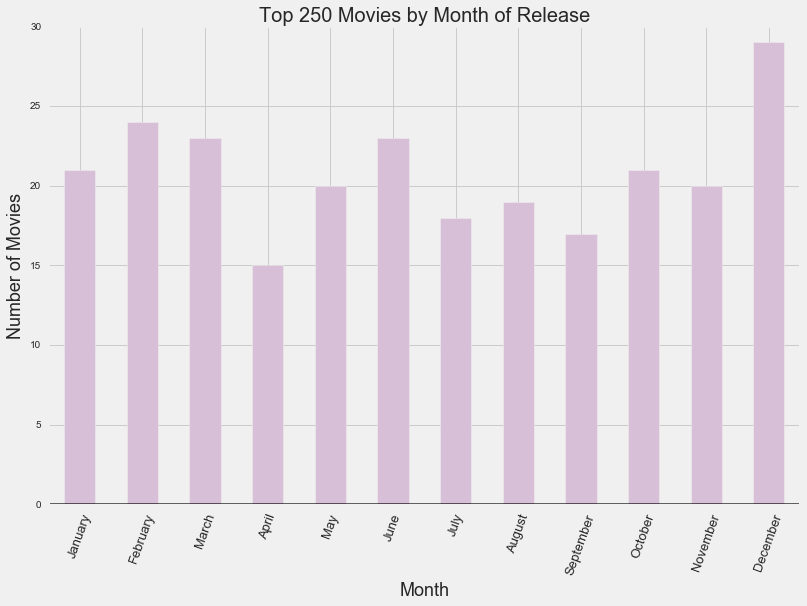

In [58]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

y['count'].plot.bar(color = 'thistle')

plt.title('Top 250 Movies by Month of Release', fontsize = 20)

# y label
plt.ylabel('Number of Movies', fontsize = 18)

# x label
plt.xlabel('Month', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation=70, fontsize = 13)
plt.show()

Let's check out where non-USA, non-UK movies are from:

In [60]:
top[(top['country'] != 'USA') & (top['country'] != 'UK')][['title', 'country']].sort('country')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,country
220,The Best Years of Our Lives,Argentina
195,Wild Tales,Argentina
168,Mary and Max,Australia
51,Sunset Blvd.,Australia
70,Vertigo,Brazil
234,Ip Man,China
107,The Hunt,Denmark
149,Incendies,France
152,The Message,France
99,Rashomon,France


A lot of these look weird... Hitchcock in Japan and Brazil?  Reservoir Dogs in France?  They must be the release locations.  Let's scrape country of origin separately and keep this as-is for now.

In [61]:
# origin = []
# for i in range(len(soup)):
#     country = []
#     for j in soup[i].find_all('a', href = re.compile('/country/')):
#         country.append(j.text.encode('utf8'))
#     if len(country) > 1:
#         mini_list = []
#         mini_list.append(country[0])
#         origin.append(mini_list)
#     else:
#         origin.append(country)

# origin = pd.DataFrame(origin)
# origin.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv', index = False)

In [62]:
origin = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/origin.csv')
top['origin'] = origin

Let's print first five examples where 'country' does not match 'origin':

In [83]:
count = 0
for i in range(len(top)):
    if top['country'][i] != top['origin'][i]:
        print top.loc[i][['title', 'country', 'origin']]
        print '\n'
        count += 1
        if count == 5:
            break

title      The Good, the Bad and the Ugly
country                               USA
origin                              Italy
Name: 8, dtype: object


title      The Lord of the Rings: The Fellowship of the Ring
country                                                  USA
origin                                           New Zealand
Name: 10, dtype: object


title      Seven Samurai
country              USA
origin             Japan
Name: 18, dtype: object


title      City of God
country            USA
origin          Brazil
Name: 20, dtype: object


title      Life Is Beautiful
country                  USA
origin                 Italy
Name: 25, dtype: object




In [120]:
comparison = []
country_compare = []
origin_compare = []
title_compare = []
year_compare = []
for i in range(len(top)):
    if top['country'][i] != top['origin'][i]:
        comparison.append(str(top['origin'][i] + ', ' + top['country'][i]))
        country_compare.append(top['country'][i])
        origin_compare.append(top['origin'][i])
        title_compare.append(top['title'][i])
        year_compare.append(top['year'][i])

df_compare = pd.DataFrame(zip(title_compare, origin_compare, country_compare, comparison, year_compare), \
                          columns = ['title', 'origin', 'country', 'origin, country', 'year']).sort('year')

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:14: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



For movies with 'origin' and 'country' not matching, what are value counts for country of origin?

In [136]:
df_compare['origin'].value_counts()

USA             18
UK              16
Italy           10
Japan            8
France           7
Germany          4
Sweden           3
Hong Kong        2
Soviet Union     2
Ireland          2
India            1
Spain            1
New Zealand      1
Argentina        1
Lebanon          1
West Germany     1
Mexico           1
Iran             1
Australia        1
Canada           1
Brazil           1
Name: origin, dtype: int64

For movies with 'origin' and 'country' not matching, what are value counts for country of release?

In [137]:
df_compare['country'].value_counts()

USA             58
UK               5
France           5
Sweden           3
Japan            2
Argentina        1
Germany          1
Hungary          1
China            1
Philippines      1
West Germany     1
Singapore        1
Netherlands      1
Australia        1
Brazil           1
Name: country, dtype: int64

For movies with 'origin' and 'country' not matching, what are the most common 'origin'-to-'country' transitions?

In [138]:
df_compare['origin, country'].value_counts()

UK, USA                      16
Italy, USA                   10
Japan, USA                    8
France, USA                   7
USA, UK                       5
Sweden, USA                   3
Germany, USA                  3
USA, France                   3
USA, Sweden                   2
USA, Japan                    2
Ireland, USA                  2
Germany, Sweden               1
West Germany, USA             1
Spain, USA                    1
Mexico, USA                   1
Canada, France                1
USA, Argentina                1
Brazil, USA                   1
New Zealand, USA              1
Argentina, USA                1
USA, West Germany             1
Soviet Union, Hungary         1
Hong Kong, USA                1
USA, Philippines              1
Hong Kong, China              1
Australia, USA                1
India, Singapore              1
Soviet Union, Netherlands     1
USA, Australia                1
USA, Brazil                   1
USA, Germany                  1
Lebanon,

Which USA movies were released in another country? 

In [126]:
df_compare[df_compare['origin'] == 'USA'][['title', 'origin', 'country', 'year']]

,title,origin,country,year
39,The Gold Rush,USA,Germany,1925
44,The General,USA,France,1926
71,The Best Years of Our Lives,USA,Argentina,1946
31,All About Eve,USA,Sweden,1950
29,Rashomon,USA,France,1950
11,Sunset Blvd.,USA,Australia,1950
8,Rear Window,USA,UK,1954
14,Paths of Glory,USA,West Germany,1957
64,Touch of Evil,USA,UK,1958
18,Vertigo,USA,Brazil,1958


In [133]:
df_compare[(df_compare['origin'] != 'USA') & (df_compare['country'] != 'USA')][['title', 'origin', 'country', 'year']]

,title,origin,country,year
19,M,Germany,Sweden,1931
49,The Message,Lebanon,France,1976
66,Stalker,Soviet Union,Netherlands,1979
52,Come and See,Soviet Union,Hungary,1985
76,Ip Man,Hong Kong,China,2008
48,Incendies,Canada,France,2010
81,Gangs of Wasseypur,India,Singapore,2012


Get director name (only take first if more than one):

In [245]:
# director = []
# for i in range(len(soup)):
#     dirs = []
#     for j in soup[i].find_all('span', itemprop = 'director'):
#         for k in j.find_all('span', itemprop = 'name'):
#             dirs.append(k.text.encode('utf8'))
# # these two lines will print all directors' names for movies with more than one director listed
# #            if len(dirs) != 1:
# #                print dirs
#     if len(dirs) > 1:
#         mini_list = []
#         mini_list.append(dirs[0])
#         director.append(mini_list)
#     else:
#         director.append(dirs)
        
# len(director)

250

In [246]:
# director = pd.DataFrame(director)
# director.to_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv', index = False)

In [140]:
director = pd.read_csv('/Users/Rebecca/DSI-projects/projects/project-06/assets/director.csv')
top['director'] = director

Who directed the Italian movies?

In [141]:
top[top['origin'] == 'Italy'][['title', 'year', 'director']].sort('year', ascending = False)

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning:

sort(columns=....) is deprecated, use sort_values(by=.....)



,title,year,director
173,Rush,2013,Federico Fellini
25,Life Is Beautiful,1997,Roberto Benigni
55,Cinema Paradiso,1988,Giuseppe Tornatore
67,Once Upon a Time in America,1984,Sergio Leone
27,Once Upon a Time in the West,1968,Sergio Leone
8,"The Good, the Bad and the Ugly",1966,Sergio Leone
230,The Battle of Algiers,1966,Gillo Pontecorvo
97,For a Few Dollars More,1965,Sergio Leone
241,A Fistful of Dollars,1964,Sergio Leone
214,8½,1963,Federico Fellini


Surprise!  There are no female directors with more than two movies in the Top 250 list:

In [144]:
dir_count = pd.DataFrame(top['director'].value_counts())
dir_count.columns = ['count']
dir_count[dir_count['count'] > 2]

,count
Stanley Kubrick,7
Steven Spielberg,7
Alfred Hitchcock,7
Christopher Nolan,7
Martin Scorsese,7
Akira Kurosawa,6
Hayao Miyazaki,6
Sergio Leone,5
Charles Chaplin,5
Billy Wilder,5


In [218]:
years_no_gross = []
country_no_gross = []
def get_gross(entry):
    count = 0
    response = requests.get('http://www.imdb.com/title/'+entry)
    html = response.text
    try:
        count += 1
        gross_list = re.findall("Gross:</h4>[ ]*\$([^ ]*)", html)
        gross = int(gross_list[0].replace(',', ''))
        return gross
    except Exception as ex:
        print '\n'
        print count
        print 'http://www.imdb.com/title/'+entry
        print top[top['tconst'] == entry][['title', 'year']]
        print '\n'
        try:
            a = years_no_gross.append(top[top['tconst'] == entry]['year'][0])
            return a
        except Exception:
            return None
        try:
            b = country_no_gross.append(top[top['tconst'] == entry]['origin'][0])
            return b
        except Exception:
            return None
        return None

In [219]:
gross = []
for extension in top['tconst']:
    gross.append(get_gross(extension))



1
http://www.imdb.com/title/tt0050083
          title  year
5  12 Angry Men  1957




1
http://www.imdb.com/title/tt0038650
                    title  year
23  It's a Wonderful Life  1946




1
http://www.imdb.com/title/tt0064116
                           title  year
27  Once Upon a Time in the West  1968




1
http://www.imdb.com/title/tt0034583
         title  year
32  Casablanca  1942




1
http://www.imdb.com/title/tt0021749
          title  year
34  City Lights  1931




1
http://www.imdb.com/title/tt0057012
                                                title  year
50  Dr. Strangelove or: How I Learned to Stop Worr...  1964




1
http://www.imdb.com/title/tt0043014
           title  year
51  Sunset Blvd.  1950




1
http://www.imdb.com/title/tt0032553
                 title  year
53  The Great Dictator  1940




1
http://www.imdb.com/title/tt0050825
             title  year
56  Paths of Glory  1957




1
http://www.imdb.com/title/tt0081505
          title  year
58  The Shinin

That is not a useful counter, is it?  Not sure what's wrong.

In [196]:
no_gross = pd.DataFrame(zip(country_no_gross, years_no_gross), \
                        columns = ['country', 'year'])
no_gross['country'] = no_gross['country'].apply(lambda x: str(x))
no_gross['year'] = no_gross['year'].apply(lambda x: str(x))
no_gross['country'] = no_gross['country'].split(' ')
no_gross['year'] = no_gross['year'].split(' ')
for i in range(len(no_gross)):
    no_gross['country'][i] == no_gross['country'][i][1]
    no_gross['year'][i] == no_gross['year'][i][1]
no_gross

AttributeError: 'Series' object has no attribute 'split'

In [159]:
foreign_notNR = top[(top['cert'] != 'Not Rated') & (top['origin'] != 'USA')]

foreign_NR = top[(top['cert'] == 'Not Rated') & (top['origin'] != 'USA')]

domestic_notNR = top[(top['cert'] != 'Not Rated') & (top['origin'] == 'USA')]

domestic_NR = top[(top['cert'] == 'Not Rated') & (top['origin'] == 'USA')]

Most 'Not Rated' and 'Approved' movies in the list are pre-1970; after 1970, almost all of the 'Not Rated' movies are non-USA.  

In [160]:
# x = float(len(foreign_notNR_post1970))/ (len(foreign_notNR_post1970) + len(foreign_NR_post1970))

# print 'Proportion of non-\'Not Rated\' foreign films to \'Not Rated\' foreign films post-1970: %s' %x

And, as we see below, all domestic films since 1970 are non-'Not Rated':

In [161]:
# y = float(len(domestic_notNR_post1970))/ (len(domestic_notNR_post1970) + len(domestic_NR_post1970))

# print 'Proportion of non-\'Not Rated\' domestic films to \'Not Rated\' domestic films post-1970: %s' %y

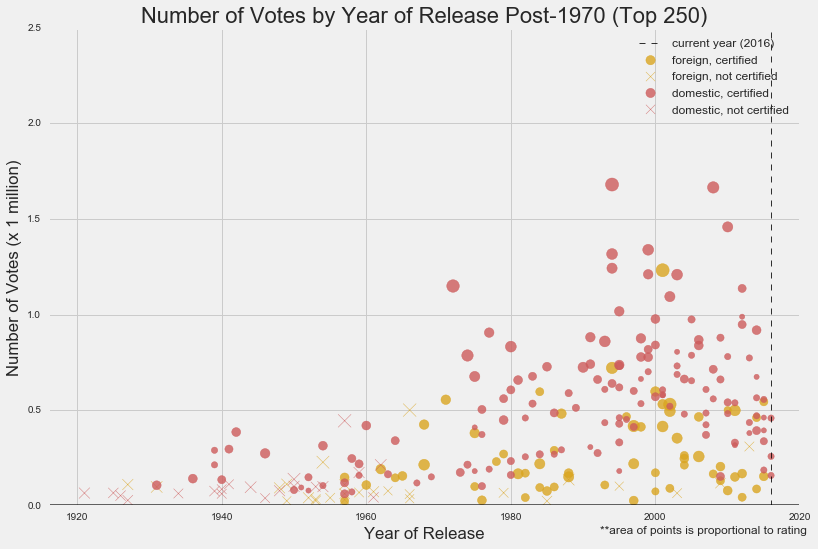

In [162]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')


# set area of dot proportional-ish to rating
area = (top_scaled['rating'] + 1.4)*30

# plot number of votes by year of release
plt.scatter(foreign_notNR['year'], foreign_notNR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'o', alpha = 0.8, \
            s = area, \
            label = 'foreign, certified')
plt.scatter(foreign_NR['year'], foreign_NR['num_votes']/1000000, color = 'GoldenRod', \
            marker = 'x', alpha = 0.8, \
            s = area, \
            label = 'foreign, not certified')
plt.scatter(domestic_notNR['year'], domestic_notNR['num_votes']/1000000, color = 'IndianRed', \
            marker = 'o', alpha = 0.8, \
            s = area, \
            label = 'domestic, certified')
plt.scatter(domestic_NR['year'], domestic_NR['num_votes']/1000000, color = 'IndianRed', \
            marker = 'x', alpha = 0.8, \
            s = area, \
            label = 'domestic, not certified')

plt.title('Number of Votes by Year of Release Post-1970 (Top 250)', fontsize = 22)

# add x-axis line and a line to show current year
plt.axhline(0, color='black', alpha = 0.6)
plt.axvline(2016, color='black', linestyle='dashed', linewidth=0.8, label = 'current year (2016)')

# y label
plt.ylabel('Number of Votes (x 1 million)')

# x label
plt.xlabel('Year of Release')

# set the figure boundaries
plt.xlim([min(top['year'])-5, 2020])
plt.ylim([0, 2.5])

plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)
plt.annotate('**area of points is proportional to rating', (1,0), (-200, -20), \
             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 12)
plt.show()

What was the last year a USA movie had no MPAA rating (certification)?